# Code for stack-exchange answer

https://stats.stackexchange.com/questions/351631/graphical-path-coordinate-descent-in-case-of-semi-differentiable-functions-such



In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model

%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
def costfunction(X,y,theta):
    #Initialisation of useful values 
    m = np.size(y)
    
    #Cost function in vectorized form
    h = X @ theta
    J = float((1./(2*m)) * (h - y).T @ (h - y));    
    return J;


def costFunctionReg(X,y,theta,lamda = 10):
    '''Compute cost for logistic regression with regularization  '''
    
    #Initializations
    #theta = theta[:,np.newaxis]
    m = len(y) 
    J = 0
    
    #Computations
    h = X @ theta
    J_reg = (lamda / (2*m)) * np.sum(np.square(theta))
    J = float((1./(2*m)) * (h - y).T @ (h - y)) + J_reg;
    
    if np.isnan(J):
        return(np.inf)
    return(J) 

def costfunctionlasso(theta, X,y, lamda = 10):
    m = len(y) 
    J = 0
    
    #Computations
    h = X @ theta
    J_reg = (lamda / (2*m)) * np.sum(np.abs(theta))
    J = float((1./(2*m)) * (h - y).T @ (h - y)) + J_reg;
    
    if np.isnan(J):
        return(np.inf)
    return(J) 
    


def gradient_descent(X,y,theta,alpha = 0.0005,num_iters=1000):
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards
    
    for i in range(num_iters):
        #Cost and intermediate values for each iteration
        J_history[i] = costfunction(X,y,theta)
        theta_0_hist.append(theta[0,0])
        theta_1_hist.append(theta[1,0])
        
        #Grad function in vectorized form
        h = X @ theta
        gradient = (1/m)*(X.T @ (h-y))
        theta = theta - alpha * gradient       
    return theta,J_history, theta_0_hist, theta_1_hist

def gradient_descent_reg(X,y,theta,alpha = 0.0005,lamda = 10,num_iters=1000):
    #Initialisation of useful values 
    m = np.size(y)
    J_history = np.zeros(num_iters)
    theta_0_hist, theta_1_hist = [], [] #Used for three d plot

    for i in range(num_iters):
        #Hypothesis function
        h = np.dot(X,theta)
        
        #Calculating the grad function in vectorized form
        theta = theta - alpha * (1/m)* (  (X.T @ (h-y)) + lamda * theta )
           
        #Cost function in vectorized form       
        J_history[i] = costFunctionReg(X,y,theta,lamda)
           
        #Calculate the cost for each iteration(used to plot convergence)
        theta_0_hist.append(theta[0,0])
        theta_1_hist.append(theta[1,0])   
    return theta ,J_history, theta_0_hist, theta_1_hist

def coordinate_descent_lasso(theta,X,y,lamda = .01, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before
    J_history = []
    theta_0_hist, theta_1_hist = [], [] #Used for three d plot
    
    J_history.append(costfunctionlasso(theta,X,y,lamda))
    theta_0_hist.append(theta[0,0])
    theta_1_hist.append(theta[1,0]) 
    
    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j].reshape(-1,1)
            y_pred = X @ theta
            rho = X_j.T @ (y - y_pred  + theta[j]*X_j)
          
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                theta[j] =  soft_threshold(rho, lamda)  
            
            #Computing values for plots
            J_history.append(costfunctionlasso(theta,X,y,lamda))
            theta_0_hist.append(theta[0,0])
            theta_1_hist.append(theta[1,0]) 
            
    return theta.flatten(), J_history, theta_0_hist, theta_1_hist

def closed_form_solution(X,y):
    return np.linalg.inv(X.T @ X) @ X.T @ y
    
def closed_form_reg_solution(X,y,lamda = 10): 
    m,n = X.shape
    I = np.eye((n))
    return (np.linalg.inv(X.T @ X + lamda * I) @ X.T @ y)[:,0]

def cost_l2(x,y):
    return x**2 + y**2

def cost_l1(x,y):
    return np.abs(x) + np.abs(y)

def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

### Simulated dataset 

In [4]:
#Creating the dataset (as previously)
x = np.linspace(0,1,40)
noise = 1*np.random.uniform(  size = 40)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = (y + noise).reshape(-1,1)
y_noise = y_noise - y_noise.mean()
X = np.vstack((x,x**2)).T

#Nornalizing the design matrix to facilitate visualization
X = X / np.linalg.norm(X,axis = 0)

#Setup of meshgrid of theta values
T0, T1 = np.meshgrid(np.linspace(7,18,100),np.linspace(-18,-9,100))


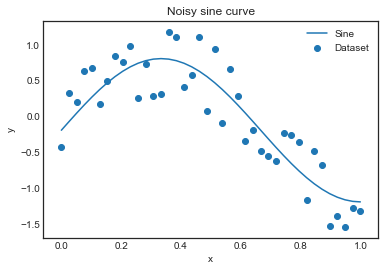

In [5]:
#Plotting the result
plt.scatter(x,y_noise, label = 'Dataset')
plt.plot(x,y - y.mean(),label = 'Sine')
plt.title('Noisy sine curve')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Checking the correlation between $x$ and $X^2$ features 

Very high (of course..)

In [16]:
#Condition number
display(np.linalg.cond(X))

#Covariance matrix
X.T@X

7.876245233535162

array([[1.        , 0.96827172],
       [0.96827172, 1.        ]])

### Calculating the path of the regularized solution as a function of lambda 

In [14]:
lambda_range = np.logspace(0,4,num = 100)/1000
theta_0_list_reg_l2 = []
theta_1_list_reg_l2 = []

for l in lambda_range:
    t0, t1 = closed_form_reg_solution(X,y_noise,l)
    theta_0_list_reg_l2.append(t0)
    theta_1_list_reg_l2.append(t1)

### Calculating the path of lasso solution as a function of lambda


In [15]:
lambda_range = np.logspace(0,2,num = 100)/1000
theta_0_list_reg_l1 = []
theta_1_list_reg_l1 = []

for l in lambda_range:
    model_sk_reg = linear_model.Lasso(alpha=l, fit_intercept=False)
    model_sk_reg.fit(X,y_noise)
    t0, t1 = model_sk_reg.coef_
    theta_0_list_reg_l1.append(t0)
    theta_1_list_reg_l1.append(t1)


### Plotting the solution path on the contour plots 

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


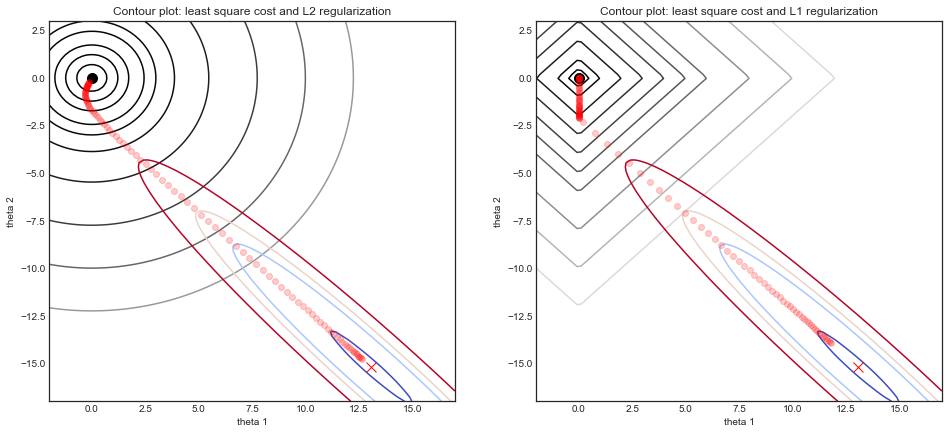

In [16]:

#Setup of meshgrid of theta values
xx, yy = np.meshgrid(np.linspace(-2,17,100),np.linspace(-17,3,100))

#Computing the cost function for each theta combination
zz_l2 = np.array(  [cost_l2(xi, yi )for xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] ) #L2 function

zz_l1 = np.array(  [cost_l1(xi, yi )for xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] ) #L1 function

zz_ls = np.array(  [costfunction(X, y_noise.reshape(-1,1),np.array([t0,t1]).reshape(-1,1)) 
                     for t0, t1 in zip(np.ravel(xx), np.ravel(yy)) ] ) #least square cost function

#Reshaping the cost values    
Z_l2 = zz_l2.reshape(T0.shape)
Z_ls = zz_ls.reshape(T0.shape)
Z_l1 = zz_l1.reshape(T0.shape)

#Defining the global min of each function
min_ls = np.linalg.inv(X.T@X)@X.T@y_noise
min_l2 = np.array([0.,0.])
min_l1 = np.array([0.,0.])

#Plotting the contours - L2 
fig = plt.figure(figsize = (16,7))
ax = fig.add_subplot(1, 2, 1)
ax.contour(xx, yy, Z_l2, levels = [.5,1.5,3,6,9,15,30,60,100,150,250],  cmap = 'gist_gray', label = 'l2')
ax.contour(xx, yy, Z_ls, levels = [.01,.06,.09,.11,.15], cmap = 'coolwarm', label = 'least squares')
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_title('Contour plot: least square cost and L2 regularization')

#Plotting the minimum - L2 
ax.plot(min_ls[0],min_ls[1], marker = 'x', color = 'red', markersize = 10)
ax.plot(0,0, marker = 'o', color = 'black', markersize = 10)

#Plotting the path of L2 regularized minimum
ax.plot(theta_0_list_reg_l2,theta_1_list_reg_l2, linestyle = 'none', marker = 'o', color = 'red', alpha = .2)


#Plotting the contours - L1 
ax = fig.add_subplot(1, 2, 2)
ax.contour(xx, yy, Z_l1, levels = [.5,1,2,3,4,5,6,8,10,12,14],  cmap = 'gist_gray', label = 'l_1')
ax.contour(xx, yy, Z_ls, levels = [.01,.06,.09,.11,.15], cmap = 'coolwarm', label = 'least squares')
ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_title('Contour plot: least square cost and L1 regularization')

#Plotting the minimum - L1
ax.plot(min_ls[0],min_ls[1], marker = 'x', color = 'red', markersize = 10)
ax.plot(0,0, marker = 'o', color = 'black', markersize = 10)

#Plotting the path of L1 regularized minimum
ax.plot(theta_0_list_reg_l1,theta_1_list_reg_l1, linestyle = 'none', marker = 'o', color = 'red', alpha = .2)

plt.show()

### Lasso coordinate descent
Vary parameter l (lamda) for different results


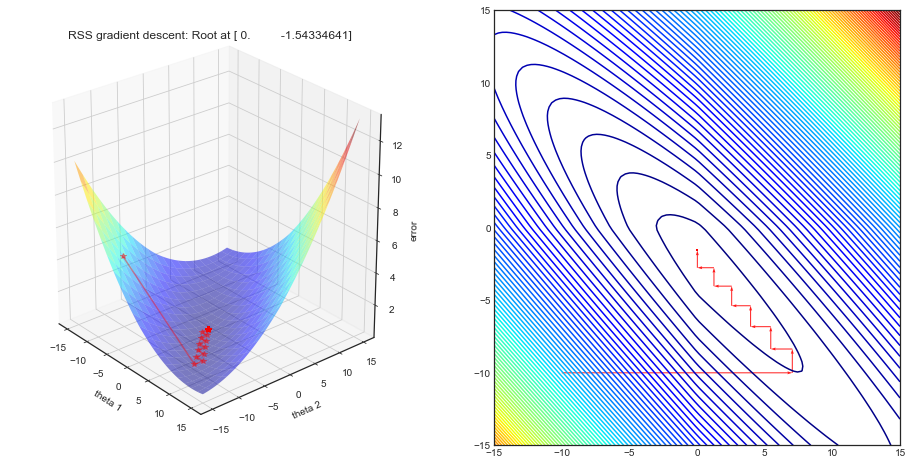

array([ 0.        , -1.54334641])

In [20]:
X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before

#PARAMETER LAMBDA
l = 1

#Setup of meshgrid of theta values
T1, T2 = np.meshgrid(np.linspace(-15,15,100),np.linspace(-15,15,100))

#Computing the cost function for each theta combination
zs = np.array(  [costfunctionlasso(np.array([t1,t2]).reshape(-1,1), X, y_noise.reshape(-1,1),l) 
                     for t1, t2 in zip(np.ravel(T1), np.ravel(T2)) ] )
#Reshaping the cost values    
Z = zs.reshape(T1.shape)


#Computing the gradient descent
theta_result_lasso,J_history_lasso, theta_0, theta_1 = coordinate_descent_lasso(np.array([-10.,-10.]).reshape(-1,1),X,y_noise,l,num_iters=1000)


#Angles needed for quiver plot
anglesx = np.array(theta_0)[1:] - np.array(theta_0)[:-1]
anglesy = np.array(theta_1)[1:] - np.array(theta_1)[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T1, T2, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(theta_0,theta_1,J_history_lasso, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_zlabel('error')
ax.set_title('RSS gradient descent: Root at {}'.format(theta_result_lasso.ravel()))
ax.view_init(25, -40)


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T1, T2, Z, 100, cmap = 'jet')
ax.quiver(theta_0[:-1], theta_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)

plt.show()
theta_result_lasso

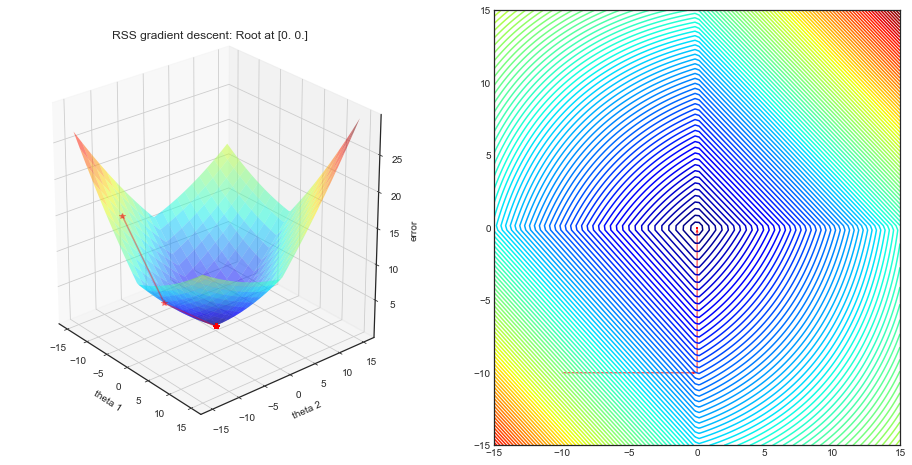

array([0., 0.])

In [21]:
X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before

#PARAMETER LAMBDA
l = 45

#Setup of meshgrid of theta values
T1, T2 = np.meshgrid(np.linspace(-15,15,100),np.linspace(-15,15,100))

#Computing the cost function for each theta combination
zs = np.array(  [costfunctionlasso(np.array([t1,t2]).reshape(-1,1), X, y_noise.reshape(-1,1),l) 
                     for t1, t2 in zip(np.ravel(T1), np.ravel(T2)) ] )
#Reshaping the cost values    
Z = zs.reshape(T1.shape)


#Computing the gradient descent
theta_result_lasso,J_history_lasso, theta_0, theta_1 = coordinate_descent_lasso(np.array([-10.,-10.]).reshape(-1,1),X,y_noise,l,num_iters=1000)


#Angles needed for quiver plot
anglesx = np.array(theta_0)[1:] - np.array(theta_0)[:-1]
anglesy = np.array(theta_1)[1:] - np.array(theta_1)[:-1]

%matplotlib inline
fig = plt.figure(figsize = (16,8))

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T1, T2, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(theta_0,theta_1,J_history_lasso, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')

ax.set_xlabel('theta 1')
ax.set_ylabel('theta 2')
ax.set_zlabel('error')
ax.set_title('RSS gradient descent: Root at {}'.format(theta_result_lasso.ravel()))
ax.view_init(25, -40)


#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T1, T2, Z, 100, cmap = 'jet')
ax.quiver(theta_0[:-1], theta_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9)

plt.show()
theta_result_lasso